In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File name (as you uploaded in Jupyter)
FILE = "enhanced_health_insurance_claims.csv"

# Load dataset
df = pd.read_csv(FILE)

print("Shape (rows, cols):", df.shape)
df.head()

Shape (rows, cols): (4500, 17)


,ClaimID,PatientID,ProviderID,ClaimAmount,ClaimDate,DiagnosisCode,ProcedureCode,PatientAge,PatientGender,ProviderSpecialty,ClaimStatus,PatientIncome,PatientMaritalStatus,PatientEmploymentStatus,ProviderLocation,ClaimType,ClaimSubmissionMethod
0,10944daf-f7d5-4e1d-8216-72ffa609fe41,8552381d-7960-4f64-b190-b20b8ada00a1,4a4cb19c-4863-41cf-84b0-c2b21aace988,3807.95,2024-06-07,yy006,hd662,16,M,Cardiology,Pending,90279.43,Married,Retired,Jameshaven,Routine,Paper
1,fcbebb25-fc24-4c0f-a966-749edcf83fb1,327f43ad-e3bd-4473-a9ed-46483a0a156f,422e02dd-c1fd-43dd-8af4-0c3523f997b1,9512.07,2023-05-30,tD052,mH831,27,M,Pediatrics,Approved,130448.02,Single,Student,Beltrantown,Routine,Online
2,9e9983e7-9ea7-45f5-84d8-ce49ccd8a4a1,6f3acdf7-73aa-4afa-9c2e-b25b27bdb5b0,f7733b3f-0980-47b5-a7a0-ee390869355b,7346.74,2022-09-27,zx832,dg637,40,F,Cardiology,Pending,82417.54,Divorced,Employed,West Charlesport,Emergency,Online
3,a06273ed-44bb-452b-bbad-8618de080494,5d58e183-701e-406c-a8c6-5b73cac5e912,f7a04581-de96-44ee-b773-8adac02baa59,6026.72,2023-06-25,kr421,kG326,65,M,Neurology,Pending,68516.96,Widowed,Student,West Aprilhaven,Routine,Phone
4,f702a717-254b-4cff-a0c7-8395db2f6616,8a8ebdf6-3af0-4f14-82f3-37b937c3d270,b80b9e77-97f0-47d7-b561-19f9658a7bdf,1644.58,2023-07-24,LZ261,cx805,24,M,General Practice,Pending,84122.17,Married,Student,Lake Michele,Inpatient,Phone


In [40]:
# --- Standardize types for reliable processing ---

# Convert ClaimDate to datetime
df["ClaimDate"] = pd.to_datetime(df["ClaimDate"], errors="coerce")

# Ensure numeric columns are numeric
df["ClaimAmount"] = pd.to_numeric(df["ClaimAmount"], errors="coerce")
df["PatientIncome"] = pd.to_numeric(df["PatientIncome"], errors="coerce")

# Strip whitespace from all string columns (common data quality issue)
for col in df.select_dtypes(include="string").columns:
    df[col] = df[col].astype(str).str.strip()

df.dtypes

ClaimID                               str
PatientID                             str
ProviderID                            str
ClaimAmount                       float64
ClaimDate                  datetime64[us]
DiagnosisCode                         str
ProcedureCode                         str
PatientAge                          int64
PatientGender                         str
ProviderSpecialty                     str
ClaimStatus                           str
PatientIncome                     float64
PatientMaritalStatus                  str
PatientEmploymentStatus               str
ProviderLocation                      str
ClaimType                             str
ClaimSubmissionMethod                 str
dtype: object

In [41]:
# --- Data Quality checks: gives governance/auditability signal ---
dq_report = {
    "total_rows": len(df),
    "duplicate_rows": int(df.duplicated().sum()),
    "null_claim_id": int(df["ClaimID"].isna().sum()),
    "null_claim_date": int(df["ClaimDate"].isna().sum()),
    "negative_claim_amounts": int((df["ClaimAmount"] < 0).sum()),
    "future_claim_dates": int((df["ClaimDate"] > pd.Timestamp.today()).sum())
}

dq_df = pd.DataFrame([dq_report])
dq_df

,total_rows,duplicate_rows,null_claim_id,null_claim_date,negative_claim_amounts,future_claim_dates
0,4500,0,0,0,0,0


In [42]:
# --- Deduplicate at the claim level ---
before = len(df)
df = df.drop_duplicates(subset=["ClaimID"])
after = len(df)

print(f"Rows before: {before}, after dedup by ClaimID: {after}")

Rows before: 4500, after dedup by ClaimID: 4500


In [43]:
# --- Fact table: claim-level events ---
fact_claims = df[[
    "ClaimID", "PatientID", "ProviderID", "ClaimDate",
    "ClaimAmount", "ClaimStatus", "ClaimType",
    "DiagnosisCode", "ProcedureCode", "ClaimSubmissionMethod"
]].copy()

# --- Patient dimension ---
dim_patients = df[[
    "PatientID", "PatientAge", "PatientGender",
    "PatientIncome", "PatientMaritalStatus", "PatientEmploymentStatus"
]].drop_duplicates().copy()

# --- Provider dimension ---
dim_providers = df[[
    "ProviderID", "ProviderSpecialty", "ProviderLocation"
]].drop_duplicates().copy()

print("fact_claims:", fact_claims.shape)
print("dim_patients:", dim_patients.shape)
print("dim_providers:", dim_providers.shape)

fact_claims: (4500, 10)
dim_patients: (4500, 6)
dim_providers: (4500, 3)


In [44]:
# --- Ensure keys in fact appear in dimensions ---
missing_patients = fact_claims.loc[~fact_claims["PatientID"].isin(dim_patients["PatientID"]), "PatientID"].nunique()
missing_providers = fact_claims.loc[~fact_claims["ProviderID"].isin(dim_providers["ProviderID"]), "ProviderID"].nunique()

print("Missing PatientIDs in dim_patients:", missing_patients)
print("Missing ProviderIDs in dim_providers:", missing_providers)

Missing PatientIDs in dim_patients: 0
Missing ProviderIDs in dim_providers: 0


In [45]:
# --- Save curated outputs for reuse (like a curated layer) ---
fact_claims.to_csv("fact_claims.csv", index=False)
dim_patients.to_csv("dim_patients.csv", index=False)
dim_providers.to_csv("dim_providers.csv", index=False)

dq_df.to_csv("dq_report.csv", index=False)

print("Saved: fact_claims.csv, dim_patients.csv, dim_providers.csv, dq_report.csv")

Saved: fact_claims.csv, dim_patients.csv, dim_providers.csv, dq_report.csv


In [46]:
# !pip install duckdb

import duckdb
con = duckdb.connect()

# Register pandas tables so we can run SQL on them
con.register("fact_claims", fact_claims)
con.register("dim_patients", dim_patients)
con.register("dim_providers", dim_providers)

print("DuckDB tables registered.")


DuckDB tables registered.


In [47]:
provider_specialty_summary = con.execute("""
SELECT
    p.ProviderSpecialty,
    COUNT(*) AS total_claims,
    SUM(f.ClaimAmount) AS total_claim_amount,
    AVG(f.ClaimAmount) AS avg_claim_amount
FROM fact_claims f
JOIN dim_providers p
ON f.ProviderID = p.ProviderID
GROUP BY 1
ORDER BY total_claim_amount DESC
""").df()

provider_specialty_summary.head(10)


,ProviderSpecialty,total_claims,total_claim_amount,avg_claim_amount
0,Pediatrics,955,4918043.88,5149.784168
1,Cardiology,907,4549260.15,5015.722326
2,Orthopedics,893,4408874.73,4937.149754
3,General Practice,880,4384549.77,4982.442920
4,Neurology,865,4303188.87,4974.784821


In [48]:
monthly_cost_trend = con.execute("""
SELECT
    strftime(f.ClaimDate, '%Y-%m') AS month,
    COUNT(*) AS total_claims,
    SUM(f.ClaimAmount) AS total_claim_amount
FROM fact_claims f
GROUP BY 1
ORDER BY 1
""").df()

monthly_cost_trend.head(10)


,month,total_claims,total_claim_amount
0,2022-07,135,627192.02
1,2022-08,192,912731.32
2,2022-09,176,877252.34
3,2022-10,197,1027010.54
4,2022-11,192,988598.28
5,2022-12,188,913328.52
6,2023-01,205,985937.96
7,2023-02,170,882716.36
8,2023-03,190,966353.28
9,2023-04,168,825358.72


In [49]:
status_by_type = con.execute("""
SELECT
    ClaimType,
    ClaimStatus,
    COUNT(*) AS claim_count
FROM fact_claims
GROUP BY 1, 2
ORDER BY 1, 3 DESC
""").df()

status_by_type.head(12)


,ClaimType,ClaimStatus,claim_count
0,Emergency,Denied,368
1,Emergency,Approved,354
2,Emergency,Pending,349
3,Inpatient,Approved,387
4,Inpatient,Pending,372
5,Inpatient,Denied,369
6,Outpatient,Approved,396
7,Outpatient,Denied,388
8,Outpatient,Pending,368
9,Routine,Denied,387


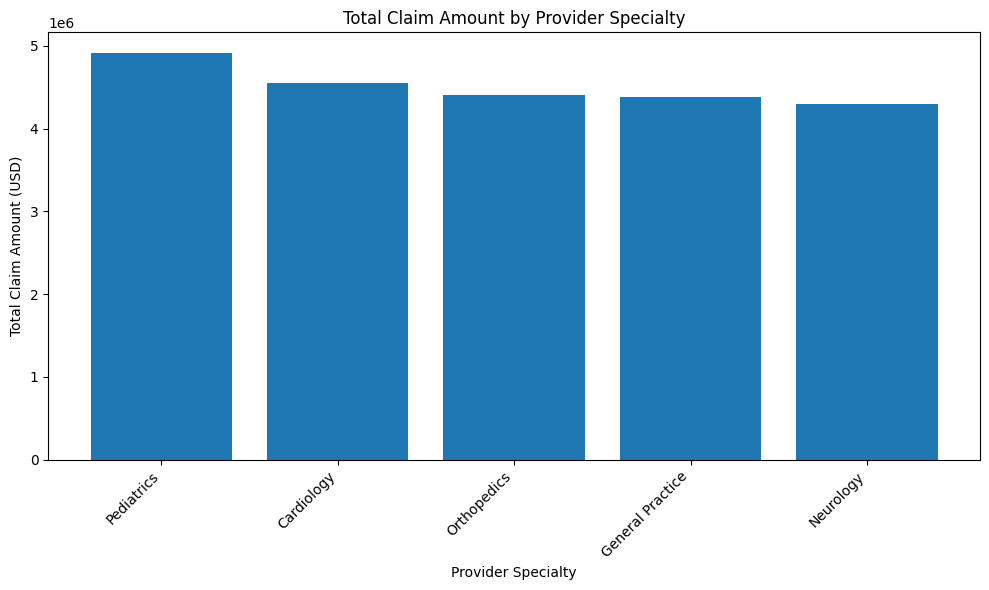

In [50]:
# Use the SQL summary table for plotting
plot_df = provider_specialty_summary.copy()

plt.figure(figsize=(10, 6))
plt.bar(plot_df["ProviderSpecialty"], plot_df["total_claim_amount"])
plt.title("Total Claim Amount by Provider Specialty")
plt.xlabel("Provider Specialty")
plt.ylabel("Total Claim Amount (USD)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


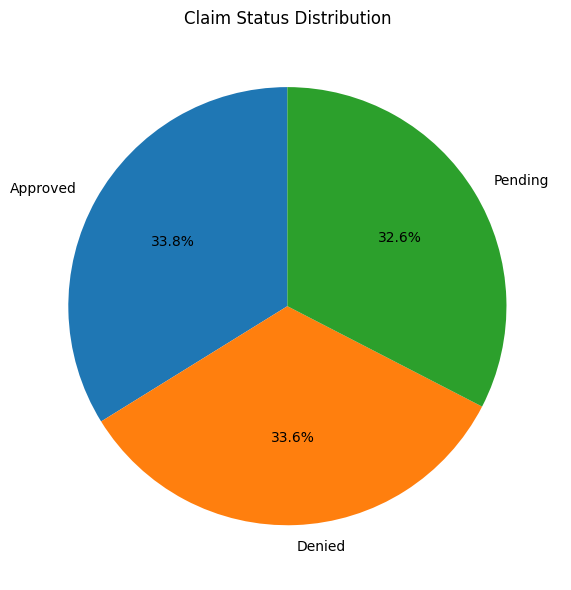

In [51]:
status_counts = fact_claims["ClaimStatus"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(status_counts.values, labels=status_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Claim Status Distribution")
plt.ylabel("")
plt.tight_layout()
plt.show()


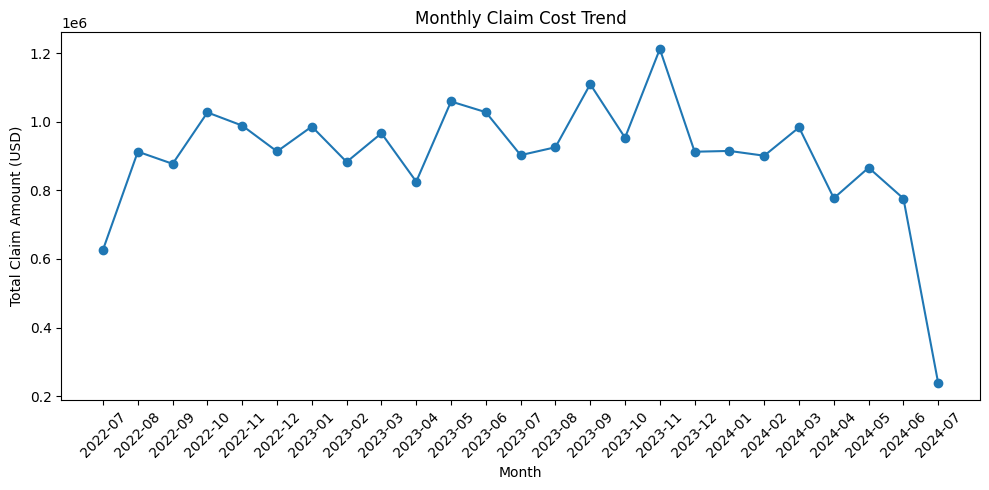

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_cost_trend["month"], monthly_cost_trend["total_claim_amount"], marker="o")
plt.title("Monthly Claim Cost Trend")
plt.xlabel("Month")
plt.ylabel("Total Claim Amount (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

ml_df = df.copy()
ml_df["is_approved"] = (ml_df["ClaimStatus"] == "Approved").astype(int)

features = [
    "ClaimAmount", "PatientAge", "PatientIncome",
    "ClaimType", "PatientGender", "ProviderSpecialty",
    "ClaimSubmissionMethod"
]

X = ml_df[features].copy()
y = ml_df["is_approved"].copy()

cat_cols = X.select_dtypes(include=["object", "string"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object", "string"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

#  handle class imbalance
model = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced"))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train)
preds = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds, zero_division=0))


Accuracy: 0.5244444444444445
              precision    recall  f1-score   support

           0       0.69      0.52      0.59       596
           1       0.36      0.54      0.43       304

    accuracy                           0.52       900
   macro avg       0.52      0.53      0.51       900
weighted avg       0.58      0.52      0.54       900

